In [ ]:
# 1) Dataset Upload
# =========================
import os
import pandas as pd

# >>> Replace this path with your CSV file path
# Required columns: 'text' (str), 'emoji' (str emoji label)
CSV_PATH = "/content/text_emoji_dataset_utf8.csv"

if os.path.exists(CSV_PATH):
    df = pd.read_csv(CSV_PATH)
else:
    # Fallback sample so the script runs even without your file
    df = pd.DataFrame({
        "text": [
            "I love pizza", "Good morning", "I am sad",
            "Party time", "I am so happy", "Feeling sleepy",
            "This is hilarious", "So angry right now", "Miss you",
            "Great job", "Let’s celebrate", "Need coffee"
        ],
        "emoji": ["🍕","☀","😢","🎉","😊","😴","😂","😡","🥺","👏","🎊","☕"]
    })

print("Dataset preview:")
print(df.head(), "\n")
assert {"text", "emoji"}.issubset(df.columns), "CSV must have 'text' and 'emoji' columns."

Dataset preview:
            text emoji
0   I love pizza     🍕
1   Good morning     ☀
2       I am sad     😢
3     Party time     🎉
4  I am so happy     😊 



In [ ]:
# 2. Load dataset
data = pd.read_csv("/content/text_emoji_dataset_utf8.csv")

In [ ]:
# 2) Library Import
# =========================
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    mean_squared_error
)
import matplotlib.pyplot as plt
import itertools
import joblib
import warnings
warnings.filterwarnings("ignore")

In [ ]:
df.head()



,text,emoji
0,I love pizza,🍕
1,Good morning,☀
2,I am sad,😢
3,Party time,🎉
4,I am so happy,😊


In [ ]:
df.tail()

,text,emoji
7,So angry right now,😡
8,Miss you,🥺
9,Great job,👏
10,Let’s celebrate,🎊
11,Need coffee,☕


In [ ]:
df.size




24

In [ ]:
df.shape

(12, 2)

In [ ]:
df.ndim

2

In [ ]:
df.empty

False

In [ ]:
df.dtypes

,0
text,object
emoji,object


In [ ]:
df.axes

[RangeIndex(start=0, stop=12, step=1),
 Index(['text', 'emoji'], dtype='object')]

In [ ]:
df.isnull()

,text,emoji
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
5,False,False
6,False,False
7,False,False
8,False,False
9,False,False


In [ ]:
df.describe()

,text,emoji
count,12,12
unique,12,12
top,I love pizza,🍕
freq,1,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    12 non-null     object
 1   emoji   12 non-null     object
dtypes: object(2)
memory usage: 324.0+ bytes


In [ ]:

df.dropna()

,text,emoji
0,I love pizza,🍕
1,Good morning,☀
2,I am sad,😢
3,Party time,🎉
4,I am so happy,😊
5,Feeling sleepy,😴
6,This is hilarious,😂
7,So angry right now,😡
8,Miss you,🥺
9,Great job,👏


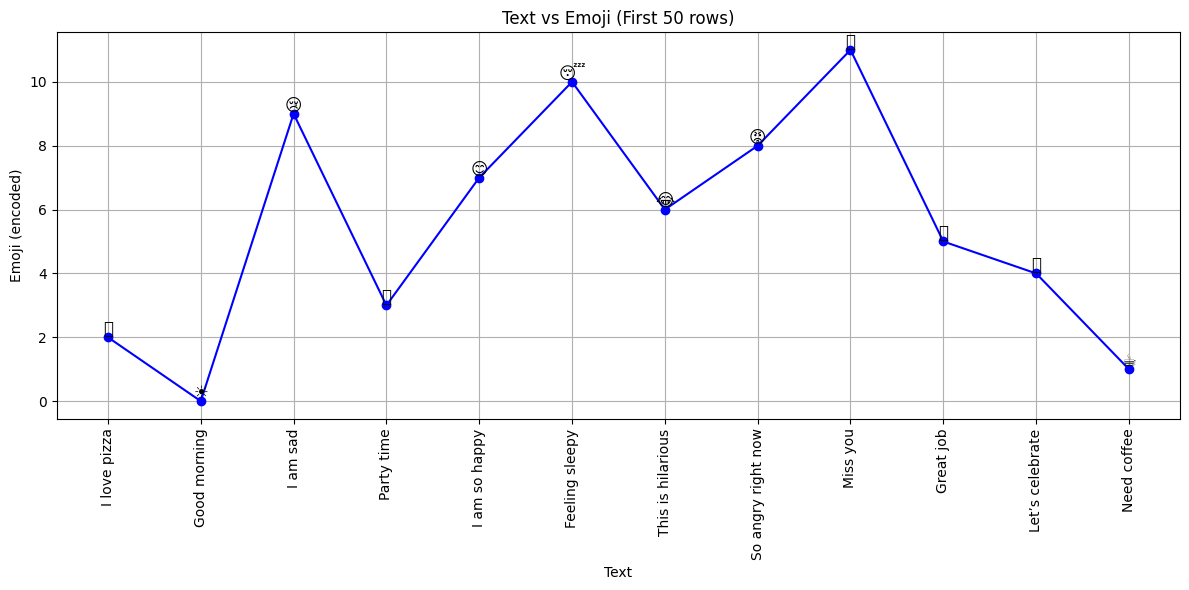

In [ ]:

# Take only first 50 rows
df_50 = df.head(50)

# Encode emojis as numbers
df_50["emoji_code"] = df_50["emoji"].astype("category").cat.codes

# Plot line graph
plt.figure(figsize=(12,6))
plt.plot(df_50["text"], df_50["emoji_code"], marker="o", linestyle="-", color="blue")

# Add emoji labels at each point
for i, emoji in enumerate(df_50["emoji"]):
    plt.text(df_50["text"].iloc[i], df_50["emoji_code"].iloc[i] + 0.1, emoji,
             fontsize=12, ha='center')

plt.xlabel("Text")
plt.ylabel("Emoji (encoded)")
plt.title("Text vs Emoji (First 50 rows)")
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()

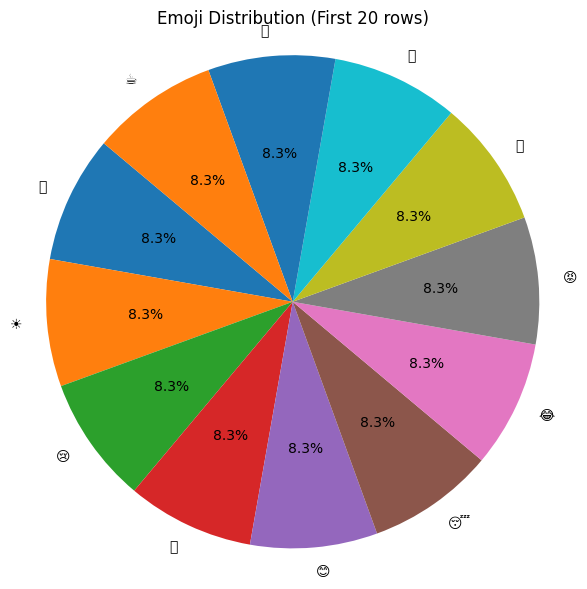

In [ ]:
# Take only first 20 rows
df_20 = df.head(20)

# Count frequency of each emoji
emoji_counts = df_20["emoji"].value_counts()

# Plot pie chart
plt.figure(figsize=(7,7))
plt.pie(
    emoji_counts,
    labels=emoji_counts.index,
    autopct="%1.1f%%", # Corrected this line
    startangle=140
)
plt.title("Emoji Distribution (First 20 rows)")
plt.axis("equal")  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

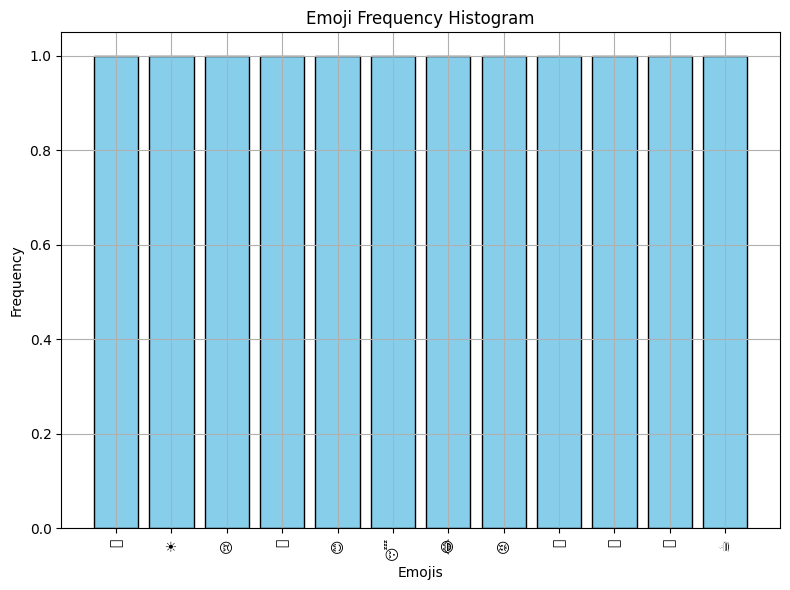

In [ ]:
# Take only first 30 rows
df_30 = df.head(30)

# Count frequency of each emoji
emoji_counts = df_30["emoji"].value_counts()

# Plot histogram (bar chart style)
plt.figure(figsize=(8,6))
plt.bar(emoji_counts.index, emoji_counts.values, color="skyblue", edgecolor="black")

plt.xlabel("Emojis")
plt.ylabel("Frequency")
plt.title("Emoji Frequency Histogram")
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# 3) Location of Index
#    (ensure clean indexing; if your CSV has an 'id' column, use it)
# =========================
if "id" in df.columns:
    df = df.set_index("id")
else:
    df = df.reset_index(drop=True)

print("Index location & shape:", df.index[:5], df.shape, "\n")

# Features and target
X = df["text"].astype(str)
y = df["emoji"].astype(str)


Index location & shape: RangeIndex(start=0, stop=5, step=1) (12, 2) 



In [ ]:
# 4) Train Test Split
# =========================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

In [ ]:
# 5) Vectorizer + 6) Train Model (Classifier)
#    Linear SVM is a strong linear baseline for text classification
# =========================
clf = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1, 2), min_df=1, max_df=0.95)),
    ("model", LinearSVC())  # strong linear classifier for text
    # If you prefer LogisticRegression:
    # ("model", LogisticRegression(max_iter=2000, n_jobs=None))
])

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)



In [ ]:
# 7) Regressor Prediction + 8) Linear Regression (for MSE demo)
#    We encode emojis → numbers, fit LinearRegression, evaluate MSE
# =========================
le = LabelEncoder()
y_num = le.fit_transform(y)

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X, y_num, test_size=0.25, random_state=42
)

vec_reg = TfidfVectorizer(ngram_range=(1, 2), min_df=1, max_df=0.95)
X_train_vec_r = vec_reg.fit_transform(X_train_r)
X_test_vec_r = vec_reg.transform(X_test_r)

reg = LinearRegression()
reg.fit(X_train_vec_r, y_train_r)
y_pred_reg_cont = reg.predict(X_test_vec_r)         # continuous predictions
y_pred_reg_round = np.clip(np.round(y_pred_reg_cont), 0, len(le.classes_) - 1).astype(int)
y_pred_reg_labels = le.inverse_transform(y_pred_reg_round)

In [ ]:
# 9) Accuracy (Classifier)
# =========================
acc = accuracy_score(y_test, y_pred)
print(f"Classifier Accuracy: {acc:.4f}")

# Optional: accuracy if you round the regressor to nearest class (not the main metric)
acc_reg_as_classifier = accuracy_score(le.inverse_transform(y_test_r), y_pred_reg_labels)
print(f"Regressor-as-Classifier Top-1 Accuracy (rounded): {acc_reg_as_classifier:.4f}")


Classifier Accuracy: 0.0000
Regressor-as-Classifier Top-1 Accuracy (rounded): 0.0000


In [ ]:
# 10) Mean Square (Regression)
# =========================
mse = mean_squared_error(y_test_r, y_pred_reg_cont)
print(f"Mean Squared Error (Regression): {mse:.4f}")



Mean Squared Error (Regression): 7.0470


In [ ]:
# 11) Classification Report
# =========================
print("\nClassification Report (Classifier):")
print(classification_report(y_test, y_pred, zero_division=0))




Classification Report (Classifier):
              precision    recall  f1-score   support

           🍕       0.00      0.00      0.00       1.0
           🎊       0.00      0.00      0.00       1.0
           👏       0.00      0.00      0.00       1.0
           🥺       0.00      0.00      0.00       0.0

    accuracy                           0.00       3.0
   macro avg       0.00      0.00      0.00       3.0
weighted avg       0.00      0.00      0.00       3.0



In [ ]:
# 12) Target of Dataset
# =========================
targets = sorted(y.unique().tolist())
print("\nTarget Classes (Emojis):", targets)




Target Classes (Emojis): ['☀', '☕', '🍕', '🎉', '🎊', '👏', '😂', '😊', '😡', '😢', '😴', '🥺']


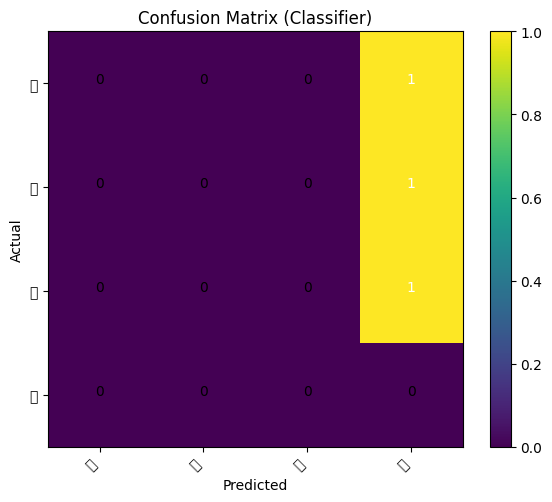

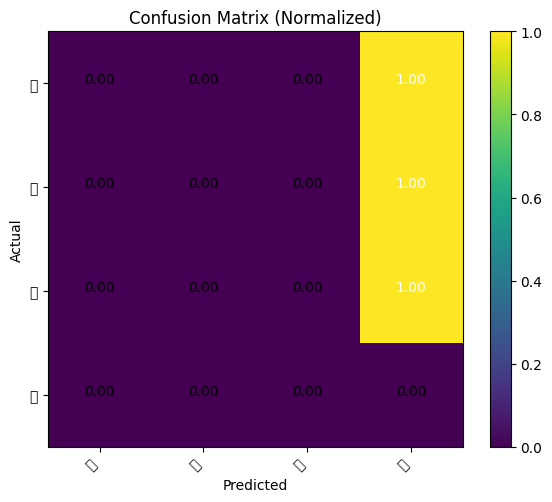

In [ ]:
# 13) Confusion Matrix
# =========================
def plot_confusion_matrix(cm, classes, title="Confusion Matrix", normalize=False):
    if normalize:
        cm = cm.astype("float") / (cm.sum(axis=1)[:, np.newaxis] + 1e-12)

    plt.figure(figsize=(6, 5))
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha="right")
    plt.yticks(tick_marks, classes)

    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.tight_layout()
    plt.show()

labels_in_order = sorted(list(set(list(y_test) + list(y_pred))))
cm = confusion_matrix(y_test, y_pred, labels=labels_in_order)
plot_confusion_matrix(cm, labels_in_order, title="Confusion Matrix (Classifier)")
plot_confusion_matrix(cm, labels_in_order, title="Confusion Matrix (Normalized)", normalize=True)



In [ ]:
# 14) Quick Inference Helpers
# =========================
def predict_emoji(texts):
    """
    Predict with the classifier (recommended).
    texts: list[str] or str
    """
    if isinstance(texts, str):
        texts = [texts]
    return clf.predict(texts)

def predict_emoji_regression(texts):
    """
    Predict with the linear regressor by rounding to nearest class (for demo).
    """
    if isinstance(texts, str):
        texts = [texts]
    Xv = vec_reg.transform(texts)
    preds = reg.predict(Xv)
    preds = np.clip(np.round(preds), 0, len(le.classes_) - 1).astype(int)
    return le.inverse_transform(preds)

print("\nDemo predictions:")
print("Classifier:", predict_emoji(["Love this!", "Feeling sleepy now", "Great work team"]))
print("Regressor (rounded):", predict_emoji_regression(["Love this!", "Feeling sleepy now", "Great work team"]))




Demo predictions:
Classifier: ['😂' '😴' '🥺']
Regressor (rounded): ['😂' '😴' '😂']


In [ ]:
# 15) Save Artifacts (Optional)
# =========================
joblib.dump(clf, "emoji_classifier.joblib")
joblib.dump(vec_reg, "emoji_vectorizer_for_reg.joblib")
joblib.dump(reg, "emoji_linear_regressor.joblib")
joblib.dump(le, "emoji_label_encoder.joblib")
print("\nSaved: emoji_classifier.joblib, emoji_vectorizer_for_reg.joblib, emoji_linear_regressor.joblib, emoji_label_encoder.joblib")


Saved: emoji_classifier.joblib, emoji_vectorizer_for_reg.joblib, emoji_linear_regressor.joblib, emoji_label_encoder.joblib


In [ ]:
import joblib


In [ ]:
# Load saved artifacts
clf = joblib.load("emoji_classifier.joblib")
vec_reg = joblib.load("emoji_vectorizer_for_reg.joblib")
reg = joblib.load("emoji_linear_regressor.joblib")
le = joblib.load("emoji_label_encoder.joblib")


In [ ]:
# Predict with classifier (recommended)
texts = ["I love this movie", "So boring", "Good morning everyone"]
pred_emojis = clf.predict(texts)
print("Predicted Emojis (Classifier):", pred_emojis)



Predicted Emojis (Classifier): ['😂' '😊' '☀']


In [ ]:
# Predict with regressor (optional demo)
import numpy as np
Xv = vec_reg.transform(texts)
pred_reg = reg.predict(Xv)
pred_reg = np.clip(np.round(pred_reg), 0, len(le.classes_)-1).astype(int)
print("Predicted Emojis (Regressor):", le.inverse_transform(pred_reg))

Predicted Emojis (Regressor): ['😂' '😊' '☀']


In [ ]:
while True:
    text = input("Enter a text (or 'quit'): ")
    if text.lower() == "quit":
        break
    emoji = clf.predict([text])[0]
    print("👉 Suggested Emoji:", emoji)

Enter a text (or 'quit'): quit


In [ ]:
pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 76.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 105.3 MB/s eta 0:00:00


In [ ]:
import streamlit as st
import joblib

# Load classifier
clf = joblib.load("emoji_classifier.joblib")

st.title("Text → Emoji Recommender 🤖")

user_input = st.text_area("Enter your text:")
if st.button("Recommend Emoji"):
    if user_input.strip():
        emoji = clf.predict([user_input])[0]
        st.write("👉 Suggested Emoji:", emoji)

2025-08-21 09:12:13.756 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-21 09:12:13.964 
  command:

    streamlit run /usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-08-21 09:12:13.965 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-21 09:12:13.966 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-21 09:12:13.967 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-21 09:12:13.968 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-21 09:12:13.969 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-21 09:12:13.970 Thread 'MainThread': mi

In [ ]:
# Create a file named app.py with the streamlit code
%%writefile app.py
import streamlit as st
import joblib

# Load classifier
clf = joblib.load("emoji_classifier.joblib")

st.title("Text → Emoji Recommender 🤖")

user_input = st.text_area("Enter your text:")
if st.button("Recommend Emoji"):
    if user_input.strip():
        emoji = clf.predict([user_input])[0]
        st.write("👉 Suggested Emoji:", emoji)

Writing app.py


In [ ]:
# Run Streamlit with ngrok
# ==============================
!pip install streamlit pyngrok -q
from pyngrok import ngrok

In [ ]:
ngrok.set_auth_token("31JxNOfRVFAC7fSRRhF8g185bIs_5TEn4aZBkZEijctzd1px3")


In [ ]:
# Start Streamlit in background
!streamlit run app.py &>/dev/null &

In [ ]:
!pkill -f ngrok


In [ ]:
# Get public URL
public_url = ngrok.connect(8501)
print("🌍 Your app is live at:", public_url)

🌍 Your app is live at: NgrokTunnel: "https://9c1e48c196c9.ngrok-free.app" -> "http://localhost:8501"
